# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.




In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
from torch.nn.functional import cross_entropy

###Now in this section we will use nn.module for class of our model

0) prepare data:

  X_train X_test ... = train_test_split() ->

  -> standart scaler (if you need) ->

  -> make torch tensor

1) Model(input, output size, forward pass)

2) Loss and optimizer

3) trainig loop:
  - forward pass: compute prediction
  - backward pass: compute gradient (from optimizer)
  - update weigths 

In [2]:
# ===================================
# 0) prepare data
# ===================================
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

print(f'Data size:\n\t train {len(train_dataset)},\n\t test {len(val_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(val_dataset[0][1])}')

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

loaders = {"train": train_dataloader, "valid": valid_dataloader}


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
print(device)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>
cuda:0


torch.Size([128, 1, 28, 28]) torch.Size([128])
784


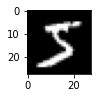

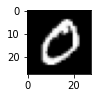

In [3]:
x_batch, y_batch = next(iter(train_dataloader))
print(x_batch.shape, y_batch.shape)

features = x_batch.shape[-1] * x_batch.shape[-2]
classes = 10
print(features)

from matplotlib import pyplot
for i in range(2):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_batch[i, 0, :, :], cmap=pyplot.get_cmap('gray'))
  pyplot.show()
     

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [4]:
# ===================================
# 1) Model(input, output size, forward pass)
# ===================================

from torchsummary import summary
model = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(features, 128), # set layers
    nn.ELU(),
    nn.Linear(128, 128), # set layers
    nn.ELU(),
    nn.Linear(128, 10) # set layers
)
model.to(device)
summary(model, (features,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [128, 128]         100,480
               ELU-2                 [128, 128]               0
            Linear-3                 [128, 128]          16,512
               ELU-4                 [128, 128]               0
            Linear-5                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 0.51
Params size (MB): 0.45
Estimated Total Size (MB): 1.34
----------------------------------------------------------------


In [5]:
# ===================================
# 2) loss andoptimizer
# ===================================

loss_model = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}


### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [6]:
# ===================================
# 2) trainig loop
# ===================================



epochs = 10

history = []
for i in range(epochs):
  for x_batch, y_batch in train_dataloader:
    # 1. # загружаем батч данных (вытянутый в линию)
    #print(x_batch.shape)
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    #print(x_batch.shape)
    y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
    logits = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = loss_model(logits, y_batch)
    history.append(loss.item())

    # 4. вычисляем градиенты
    optimizer.zero_grad()
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')
     

1,	 loss: 0.04557351768016815
2,	 loss: 0.0335855633020401
3,	 loss: 0.019745666533708572
4,	 loss: 0.015329609625041485
5,	 loss: 0.016156069934368134
6,	 loss: 0.011081964708864689
7,	 loss: 0.008229149505496025
8,	 loss: 0.01201683096587658
9,	 loss: 0.018119579181075096
10,	 loss: 0.02367370016872883


In [7]:
#max_epochs = 10
#accuracy = {"train": [], "valid": []}
#for epoch in range(max_epochs):
 #   for k, dataloader in loaders.items():
  #      epoch_correct = 0
   #     epoch_all = 0
   #     for x_batch, y_batch in dataloader:
   #         if k == "train":
   #              # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
   #         else:
   #              # YOUR CODE. Set model to ``eval`` mode and calculate outputs
   #         preds = outp.argmax(-1)
   #         correct =  # YOUR CODE GOES HERE
   #         all =  # YOUR CODE GOES HERE
   #         epoch_correct += correct.item()
   #         epoch_all += all
   #         if k == "train":
   #             loss = criterion(outp, y_batch)
   #             # YOUR CODE. Calculate gradients and make a step of your optimizer
   #     if k == "train":
  #         print(f"Epoch: {epoch+1}")
   #     print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
   #     accuracy[k].append(epoch_correct/epoch_all)


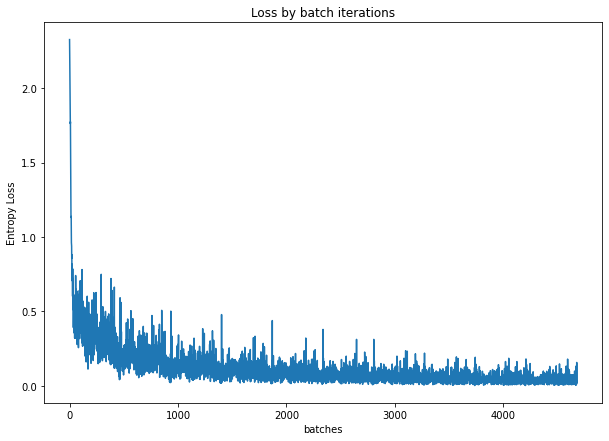

In [8]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [9]:

from sklearn.metrics import accuracy_score
acc = 0
batches = 0

for x_batch, y_batch in valid_dataloader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')
     

Test accuracy 0.952


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

--2023-01-15 18:03:34--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-01-15 18:03:35--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   165KB/s    in 0.3s    

2023-01-15 18:03:36 (165 KB/s) - ‘sample_photo.jpg’ saved [49337/4

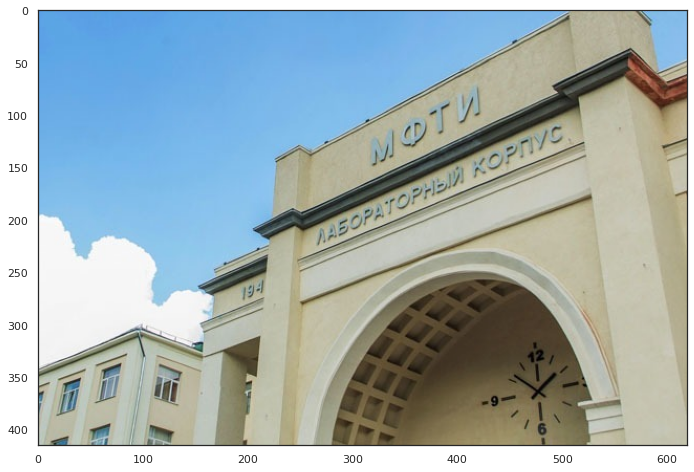

In [10]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

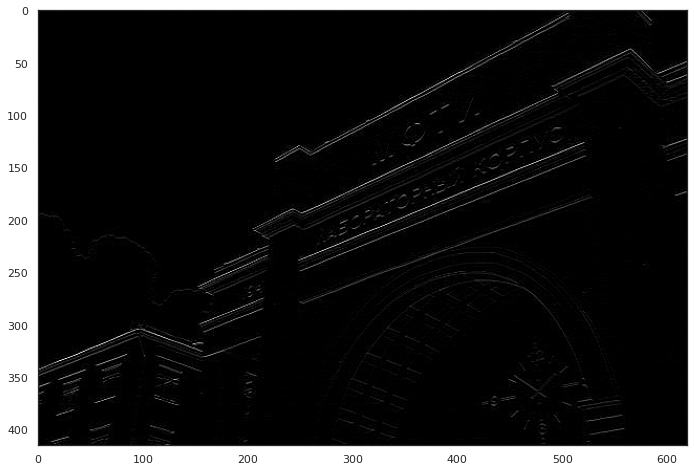

In [11]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.rearangement = nn.Flatten()
        #self.fc1 = nn.Linear(self.size_after_pooling_x * self.size_after_pooling_y * self.size_after_pooling_z, 120)  # !!!
        self.lin1 = nn.Linear(5 * 5 * 16, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x


model = LeNet()

In [32]:

summary(model.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [33]:
from tqdm import tqdm_notebook
# объявляем сеть
model = LeNet().to(device)

# выбираем функцию потерь
loss_model = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

<ipython-input-34-78ca010d47f1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-34-78ca010d47f1>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/468 [00:00<?, ?it/s]

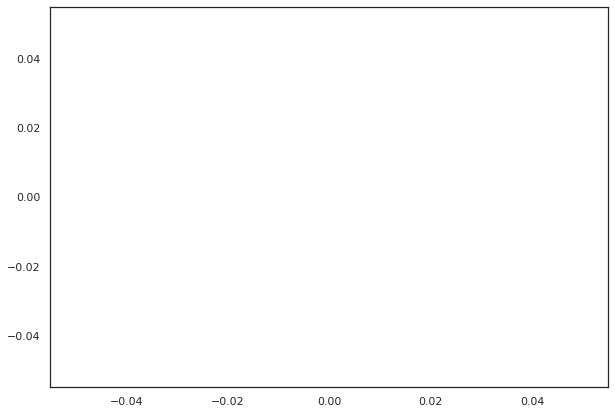

<ipython-input-34-78ca010d47f1>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/468 [00:00<?, ?it/s]

Обучение закончено


In [34]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm_notebook(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(train_dataloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch.to(device))
        loss = loss_model(y_pred, y_batch.to(device))
        
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad(): # without learning
    for data in valid_dataloader:
        images, labels = data
        y_pred = model(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 97 %
Accuracy of     3 : 96 %
Accuracy of     4 : 97 %
Accuracy of     5 : 95 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 94 %
